# Xây dựng cây quyết định và rừng cây trên dữ liệu bệnh tiểu đường.

## 1. Tải các thư viện cần thiết

In [2]:
# Các thư viện cơ bản
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 # Điều chỉnh độ phân giải nếu cần
import graphviz # Thư viện vẽ cây

# Các module từ Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score # Để đánh giá mô hình (ví dụ)

## 2. Nạp dữ liệu

In [3]:

df_diabetes = pd.read_csv('data/diabetes_prediction_dataset.csv')
print("Tải dữ liệu diabetes_prediction_dataset.csv thành công!")
print("\nXem qua vài dòng đầu:")
print(df_diabetes.head())
print("\nThông tin chung:")
df_diabetes.info()
print("\nKiểm tra giá trị thiếu:")
print(df_diabetes.isnull().sum())


Tải dữ liệu diabetes_prediction_dataset.csv thành công!

Xem qua vài dòng đầu:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Thông tin chung:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --

## 3. Tiền xử lý dữ liệu và Chọn đặc trưng

### 3a. Chuyển đổi dữ liệu hạng mục (Categorical):

In [4]:
print("\nCác giá trị duy nhất trong cột 'gender':", df_diabetes['gender'].unique())
print("Các giá trị duy nhất trong cột 'smoking_history':", df_diabetes['smoking_history'].unique())

# Áp dụng One-Hot Encoding
df_diabetes_processed = pd.get_dummies(df_diabetes, columns=['gender', 'smoking_history'], drop_first=True)

print("\nDataFrame sau khi One-Hot Encoding:")
print(df_diabetes_processed.head())
print("\nTên các cột mới:")
print(df_diabetes_processed.columns)


Các giá trị duy nhất trong cột 'gender': ['Female' 'Male' 'Other']
Các giá trị duy nhất trong cột 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']

DataFrame sau khi One-Hot Encoding:
    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0        False         False                    False   
1         0        False         False                    False   
2         0         True         False                    False   
3         0        False      

### 3b. Xác định danh sách đặc trưng (features) và tách X, y:

In [5]:
# Danh sách features bao gồm các cột số ban đầu và các cột mới tạo ra từ get_dummies
# Loại bỏ cột target 'diabetes'
features = list(df_diabetes_processed.columns)
features.remove('diabetes')

print("\nDanh sách các features sẽ sử dụng:")
print(features)

X = df_diabetes_processed[features].values
y = df_diabetes_processed['diabetes'].values

print(f"\nKích thước ma trận X: {X.shape}")
print(f"Kích thước vector y: {y.shape}")


Danh sách các features sẽ sử dụng:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_Male', 'gender_Other', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']

Kích thước ma trận X: (100000, 13)
Kích thước vector y: (100000,)


## 4. Chia dữ liệu thành tập huấn luyện và tập kiểm thử

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Thêm stratify=y để đảm bảo tỉ lệ lớp diabetes trong tập train và test tương đồng

print(f"\nKích thước X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}, y_test: {y_test.shape}")


Kích thước X_train: (80000, 13), X_test: (20000, 13)
Kích thước y_train: (80000,), y_test: (20000,)


## 5. Xây dựng cây quyết định

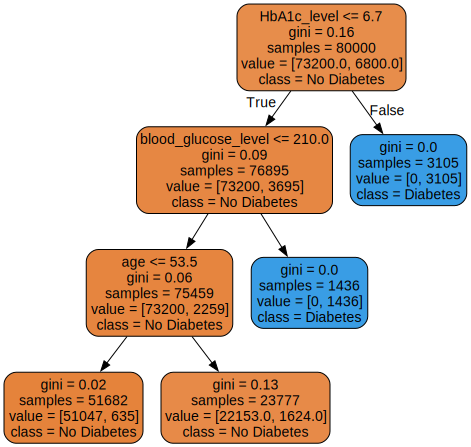

In [7]:
# Tạo và huấn luyện mô hình cây quyết định với độ sâu giới hạn (ví dụ max_depth=3)
dt_diabetes = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt_diabetes.fit(X_train, y_train)

# Trực quan hóa cây
dot_data_diabetes = tree.export_graphviz(dt_diabetes,
                                         out_file=None,
                                         filled=True,
                                         rounded=True,
                                         feature_names=features, # Danh sách features đã xác định
                                         proportion=False, # Hiển thị số lượng mẫu
                                         class_names=['No Diabetes', 'Diabetes'], # Tên lớp
                                         precision=2) # Số chữ số thập phân
graph_diabetes_dt = graphviz.Source(dot_data_diabetes)

# Hiển thị biểu đồ
graph_diabetes_dt


## 6. Tìm tham số tối ưu cho cây quyết định

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Tham số max_depth tốt nhất cho Cây Quyết Định (Diabetes): {'max_depth': 10}
Điểm ROC AUC tốt nhất trên tập validation: 0.9736


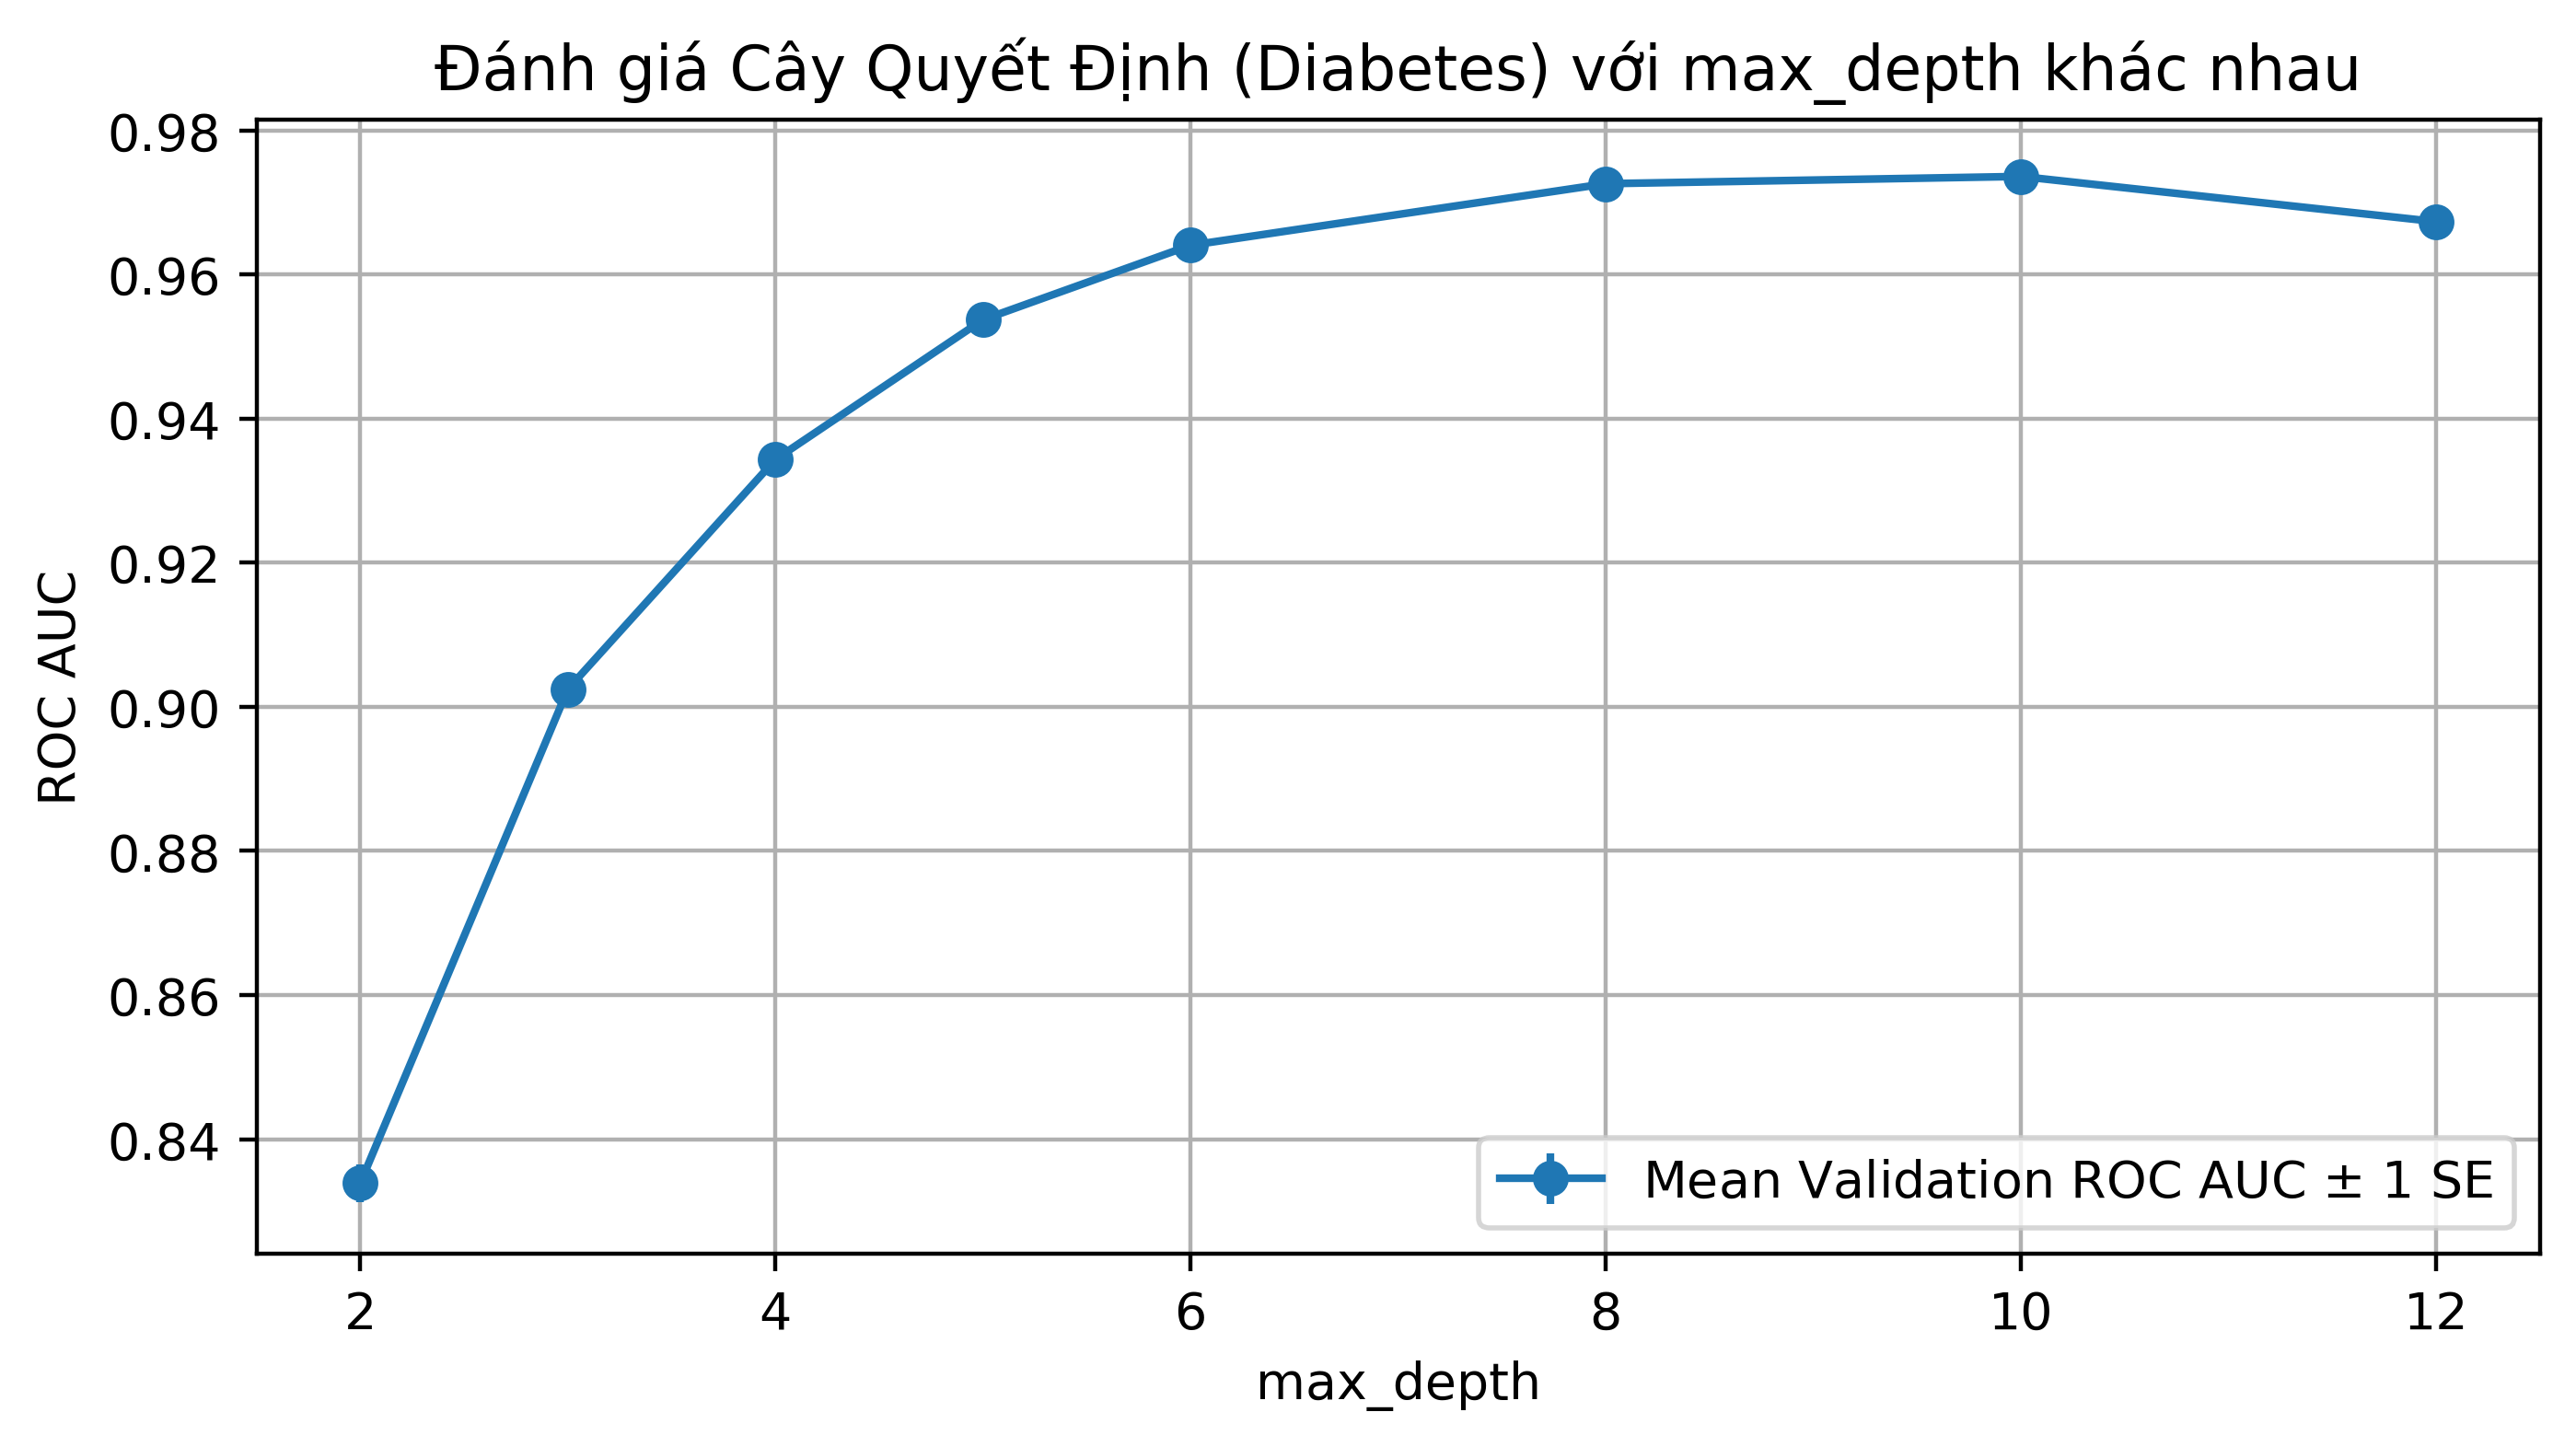

In [8]:
# Định nghĩa không gian tham số cần tìm kiếm
params_dt_diabetes = {'max_depth': [2, 3, 4, 5, 6, 8, 10, 12]} # Giảm bớt số lượng để chạy nhanh hơn

# Tạo đối tượng GridSearchCV
cv_dt_diabetes = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                              param_grid=params_dt_diabetes,
                              scoring='roc_auc', # Hoặc 'accuracy', 'f1' tùy mục tiêu
                              cv=5, # 5-fold cross-validation
                              verbose=1,
                              return_train_score=True)

# Huấn luyện (có thể mất một lúc tùy thuộc vào dữ liệu và số tham số)
cv_dt_diabetes.fit(X_train, y_train)

print(f"\nTham số max_depth tốt nhất cho Cây Quyết Định (Diabetes): {cv_dt_diabetes.best_params_}")
print(f"Điểm ROC AUC tốt nhất trên tập validation: {cv_dt_diabetes.best_score_:.4f}")

# Vẽ biểu đồ kết quả
cv_results_dt_df_diabetes = pd.DataFrame(cv_dt_diabetes.cv_results_)

plt.figure(figsize=(8, 4))
plt.errorbar(cv_results_dt_df_diabetes['param_max_depth'],
             cv_results_dt_df_diabetes['mean_test_score'],
             yerr=cv_results_dt_df_diabetes['std_test_score'] / np.sqrt(cv_dt_diabetes.cv),
             label='Mean Validation ROC AUC $\\pm$ 1 SE', marker='o')
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.title('Đánh giá Cây Quyết Định (Diabetes) với max_depth khác nhau')
plt.legend()
plt.grid(True)
plt.show()

## 7. Xây dựng Rừng Ngẫu Nhiên


Sử dụng max_depth=10 cho Random Forest.
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Tham số n_estimators tốt nhất cho Rừng Ngẫu Nhiên (Diabetes): {'n_estimators': 100}
Điểm ROC AUC tốt nhất trên tập validation: 0.9719


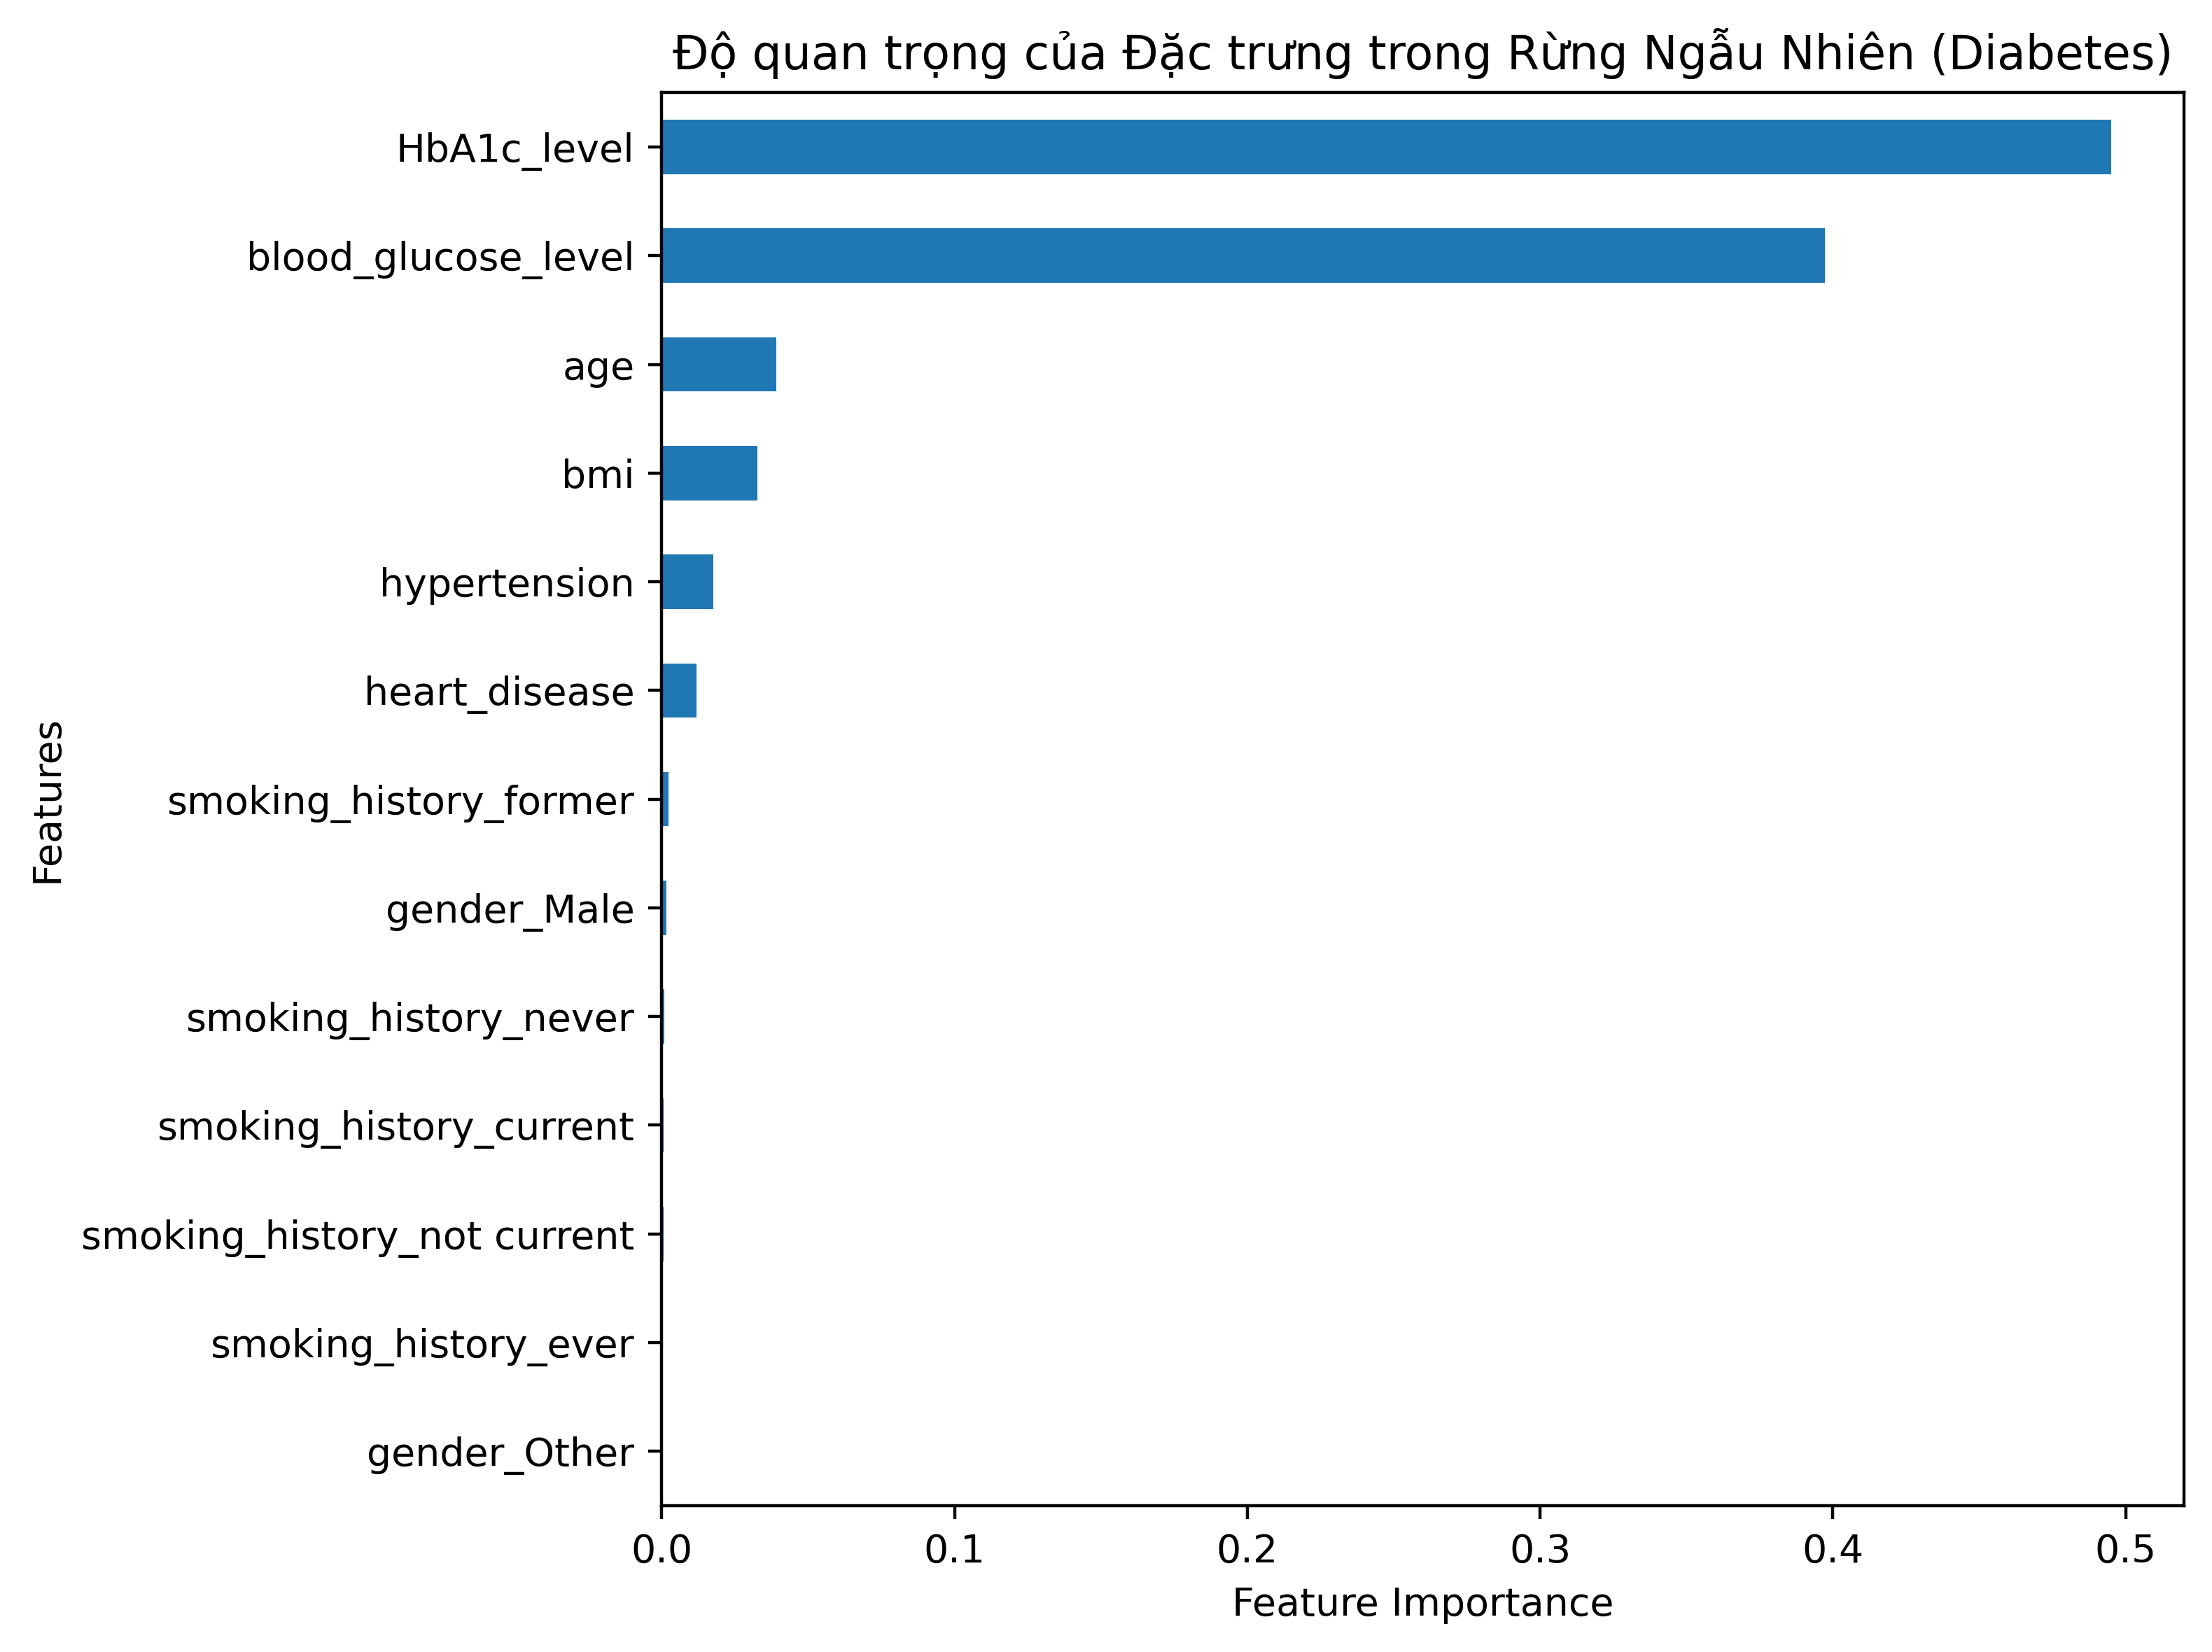

In [9]:
# Lấy max_depth tốt nhất từ bước trước để dùng cho Random Forest
best_dt_depth = cv_dt_diabetes.best_params_['max_depth']
print(f"\nSử dụng max_depth={best_dt_depth} cho Random Forest.")

# Tạo mô hình Random Forest cơ sở
rf_diabetes = RandomForestClassifier(max_depth=best_dt_depth, # Sử dụng độ sâu tốt nhất
                                     random_state=42)

# Định nghĩa không gian tham số (số lượng cây)
params_rf_diabetes = {'n_estimators': [50, 100, 150, 200]} # Giảm bớt để chạy nhanh hơn

# Tạo đối tượng GridSearchCV
cv_rf_diabetes = GridSearchCV(rf_diabetes,
                              param_grid=params_rf_diabetes,
                              scoring='roc_auc',
                              cv=5,
                              verbose=1,
                              return_train_score=True)

# Huấn luyện (có thể mất nhiều thời gian hơn cây quyết định)
cv_rf_diabetes.fit(X_train, y_train)

print(f"\nTham số n_estimators tốt nhất cho Rừng Ngẫu Nhiên (Diabetes): {cv_rf_diabetes.best_params_}")
print(f"Điểm ROC AUC tốt nhất trên tập validation: {cv_rf_diabetes.best_score_:.4f}")

# Lấy mô hình tốt nhất
best_rf_diabetes = cv_rf_diabetes.best_estimator_

# Xem độ quan trọng của đặc trưng
feat_imp_rf_df_diabetes = pd.DataFrame({
    'Importance': best_rf_diabetes.feature_importances_
}, index=features)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(8, 6)) # Tăng chiều cao biểu đồ nếu nhiều features
feat_imp_rf_df_diabetes.sort_values('Importance', ascending=True).plot(kind='barh', legend=False, ax=plt.gca())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Độ quan trọng của Đặc trưng trong Rừng Ngẫu Nhiên (Diabetes)')
plt.tight_layout()
plt.show()